

```
# Tiene formato de código
```

#Transformer Challenge

## 1. Introduccioón y Metodología:

Para este reto se utilizaró el [código base](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/) para la traducción de inglés a español con un modelo de tipo *Transformer*. Se realizaron algunos cambios sobre el código oroginal, sobre todo para poder guardar los modelos con las capas personalizadas y obtener la extracción de las matrices de atención para las gráficas del punto 5.

### 1.1 Datos utilizados

Para el entrenamiento se tuliaron los datos de **Anki** (**spa-eng.zip**) descargado desde **TensorFlow datasets**, que contiene pares de oraciones en ambos idiomas, tal que, siguiendo el código base original los datos se dividieron como:

- 70% entrenamiento.
- 15% validación
- 15% pruebas

Para la parte **6** del challenge se usaron:
- Se ejecutaron 30 epocas por modelo
- Se usaron n-gramas de tamaño 35
- Se cambió la taza de aprendizaje de 0.0005
- Se usaron cuatro optimizadores diferentes simultaneos (RMSprop, Adam, SGD y Adagrad)
- Se cambiaron las métricas de evaluacion a **BLEU** y **ROUGE**

### 1.2 Sobre los modelos:

Se añadio un $\texttt{dropout}$ de **50%** para reducir el sobre ajuste del modelo.

Como ya se mencionó, por optimizador, se guardaron dos modelos: uno con *Transformer tradicional* que generaba traducciones sin almacenar matrices de atención, y otro con visualización de atención que, además de generar traducciones, permitia extraer y visualizar las matrices de atención multi-cabeza del decodificador.

Tal que la diferencia estaba en la salida del modelo como $\texttt{outputs=[predictions, attention_scores]}$. Se hizo asi porque era más facil utilizar dos modelos por separado que tratar de manejar el modelo con doble salida, esto más que nada debido al tiempo que se perdió tratando de correr los entrenamientos en una computadora gamer.

### 1.3 Herramientas

La primera corrida del archivo se hizo con una computadora gamer, sin embargo, al ver que no era suficiente para correr las 30 epocas de entrenamiento, se opto por utilizar **Google Colab Pro**.

Con esto se paso de un tiempo de ejecución promedio de **8 minutos** por epoca a **16 segundos**.

### 1.4 Incorporación de Embeddings Pre-entrenados

Para mejorar la representación semántica de las palabras, se incorporaron embeddings pre-entrenados de GloVe (Global Vectors for Word Representation) con 100 dimensiones. Estos embeddings reemplazaron la inicialización aleatoria en la capa de embedding del modelo.

### 1.5 Evaluación del Modelo

El modelo fue evaluado utilizando métricas estándar en traducción automática:

BLEU (Bilingual Evaluation Understudy): Evalúa la similitud entre la traducción generada y la referencia humana en términos de n-gramas.

ROUGE (Recall-Oriented Understudy for Gisting Evaluation): Se calcularon las variantes ROUGE-1, ROUGE-2 y ROUGE-L para evaluar la cobertura de palabras y frases entre la traducción generada y la referencia.

Se realizaron las mismas pruebas para los cuatro optimzadores.

In [ ]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import os
import urllib.request
import zipfile
import keras
import nltk


import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras.ops as ops




from keras.models import load_model
from keras import ops
from keras.layers import TextVectorization
from keras import layers, ops
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [ ]:

# Ruta del archivo en Colab
text_file = "/content/spa-eng/spa.txt"

# Verificar si el archivo existe
if not os.path.exists(text_file):
    print("Archivo no encontrado. Descargando...")
    !wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
    !unzip -q spa-eng.zip -d /content/

# Confirmar que el archivo está en la ubicación correcta
print(f"Ruta del archivo: {text_file}")
print("¿Existe el archivo?", os.path.exists(text_file))

Ruta del archivo: /content/spa-eng/spa.txt
¿Existe el archivo? True


Para poder correr el código del articulo original, solo se tuvo que agregar $\texttt{utf-8}$ como **encoding**.

In [ ]:


with open(text_file, encoding="utf-8" ) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

('The lovers exchanged numerous letters.', '[start] Los amantes se intercambiaron varias cartas. [end]')
('The results of the competition will be announced in a few moments.', '[start] El resultado del campeonato será anunciado en pocos instantes. [end]')
('It was only when I met him that I realized his true intention.', '[start] Tan sólo al encontrarlo me di cuenta de su verdadera intención. [end]')
("Let's go for a ride.", '[start] Vamos a dar una vuelta. [end]')
('Tom puts a lot of sugar and cream in his coffee.', '[start] Tom le pone mucho azúcar y crema a su café. [end]')


In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 10000
sequence_length = 35
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)


In [ ]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 35)
inputs["decoder_inputs"].shape: (64, 35)
targets.shape: (64, 35)


Se uso el $\texttt{@keras.saving.register_keras_serializable()}$ para poder guardar las capas personalizadas en los archivos $\texttt{.keras}$ y no tener que recargar el modelo cada que se quisiera ejecutar.

In [ ]:

# Registramos la capa personalizada
@keras.saving.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


# Registramos la capa personalizada
@keras.saving.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

# Registramos la capa personalizada
@keras.saving.register_keras_serializable()
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_causal_attention_mask(self, inputs):
      input_shape = tf.shape(inputs)
      batch_size, sequence_length = input_shape[0], input_shape[1]

       # Creamos una matriz triangular superior para bloquear futuras posiciones
      i = tf.range(sequence_length)[:, None]
      j = tf.range(sequence_length)
      mask = tf.cast(i >= j, dtype="int32")  # Matriz de máscara triangular

      # Expandimos para aplicarla sobre batch y cabezas de atención
      mask = tf.reshape(mask, (1, sequence_length, sequence_length))
      mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1])], axis=0)
      return tf.tile(mask, mult)


    def call(self, inputs, mask=None, return_attention=False):
      inputs, encoder_outputs = inputs
      causal_mask = self.get_causal_attention_mask(inputs)  # 🔹 Usamos la función ahora definida

      if mask is None:
          inputs_padding_mask, encoder_outputs_padding_mask = None, None
      else:
          inputs_padding_mask, encoder_outputs_padding_mask = mask

      # Primera capa de autoatención del decoder
      attention_output_1, attention_scores_1 = self.attention_1(
          query=inputs,
          value=inputs,
          key=inputs,
          attention_mask=causal_mask,
          query_mask=inputs_padding_mask,
          return_attention_scores=True
      )
      out_1 = self.layernorm_1(inputs + attention_output_1)

      # Segunda capa de atención cruzada con el encoder
      attention_output_2, attention_scores_2 = self.attention_2(
          query=out_1,
          value=encoder_outputs,
          key=encoder_outputs,
          query_mask=inputs_padding_mask,
          key_mask=encoder_outputs_padding_mask,
          return_attention_scores=True
      )
      out_2 = self.layernorm_2(out_1 + attention_output_2)

      proj_output = self.dense_proj(out_2)
      output = self.layernorm_3(out_2 + proj_output)

      # Si return_attention es True, devolvemos también las matrices de atención
      if return_attention:
        # Aqui se genera la versión de los modelos que tiene las matrices de atención
          return output, attention_scores_2

      return output


Definimos la funcion $\texttt{build_transformer_model}$ similar a la implementación del código oroginal, pero con la intencion de usarla como una llamada ya que vamos a entrenar nuestro modelo sobre cuatro optimizadores diferentes.

Aquí la diferencia más importante radica en que la salida de la función contempla los *atention scores* que usaremos para visualziar el modelo como un **heatmap**.



In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

# Definimos este proceso como una función para poder reutilizarlo con nuestro optimizadores.

# Definimos las entradas del encoder y aplicamos embedings posicionales y luego las pasemos por el TransformerEncoder
def build_transformer_model(embed_dim, latent_dim, num_heads, vocab_size, return_attention=False):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    encoder_x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoder_x)

    # Definimos la entrada del decoder y aplicamos embeddings posicionales a las entradas del decoder
    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    decoder_x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

    # Instanciamos la capa del TransformerDecoder, A diferencia del modelo original aqui la salida incluye
    # los atention scores
    decoder_layer = TransformerDecoder(embed_dim, latent_dim, num_heads)
    decoder_output_x, attention_scores = decoder_layer([decoder_x, encoder_outputs], return_attention=True)

    # Definimos un modelo especial para inferencia que devuelve las matrices de atención
    decoder_output_final = layers.Dropout(0.5)(decoder_output_x)
    predictions = layers.Dense(vocab_size, activation="softmax")(decoder_output_final)

    if return_attention:
        model = keras.Model(
            inputs={"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
            outputs=[predictions, attention_scores],
            name="transformer_with_attention"
        )
    else:
        model = keras.Model(
            inputs={"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
            outputs=predictions,
            name="transformer"
        )

    return model





Aqui generamos un diccionario con los nombres de los optimizadores como $\texttt{keys}$ sobre el cual iteraremos para entrenar los cuatro modelos.

Ademas, generamos otro diccionario $\texttt{training_histories = {}}$ para guardar las perdidas y precisión por epoca y optimización.


Entrenando con RMSprop...

Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 101s 46ms/step - accuracy: 0.0555 - loss: 5.2041 - val_accuracy: 0.1057 - val_loss: 3.0348
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1088 - loss: 2.9742 - val_accuracy: 0.1213 - val_loss: 2.4505
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1233 - loss: 2.4205 - val_accuracy: 0.1283 - val_loss: 2.1854
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1309 - loss: 2.1429 - val_accuracy: 0.1321 - val_loss: 2.0630
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1356 - loss: 1.9792 - val_accuracy: 0.1341 - val_loss: 1.9917
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1401 - loss: 1.8402 - val_accuracy: 0.1347 - val_loss: 1.9971
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1427 - loss: 1.7610 - val_accuracy: 0.1361 - val_loss: 1.9853
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 16s 1

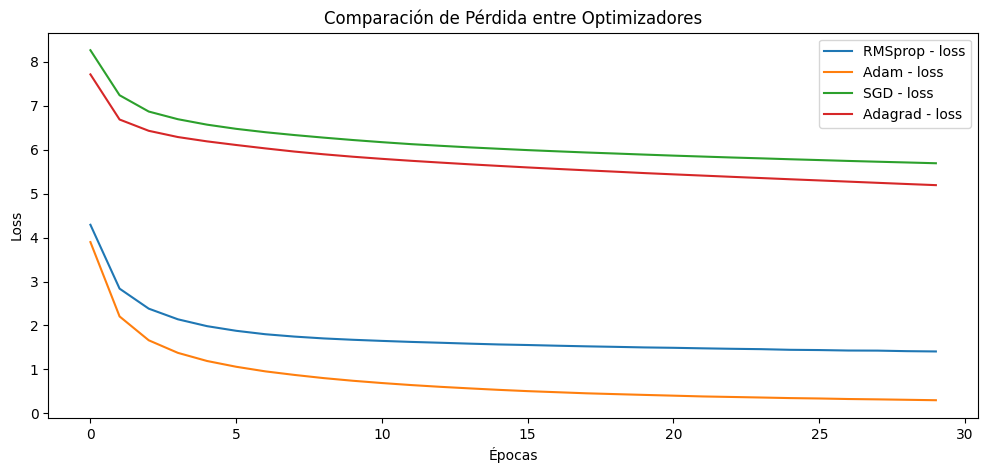

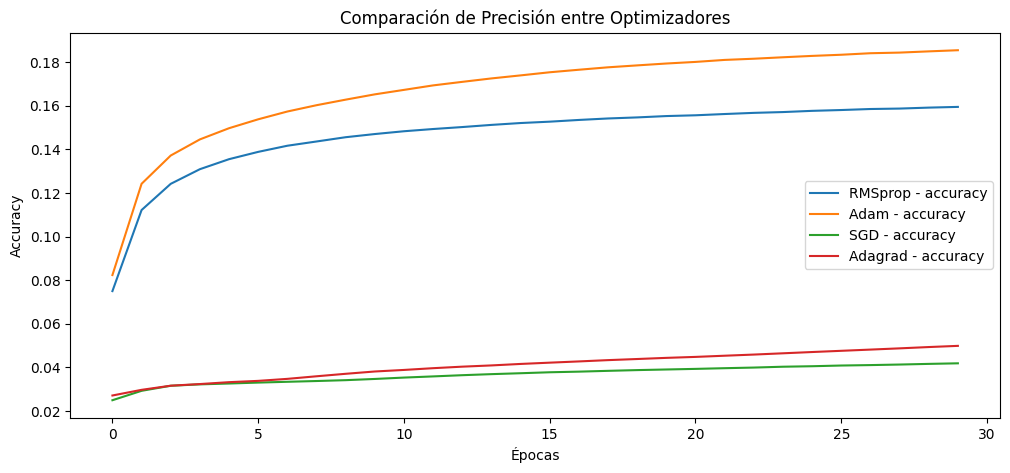

In [ ]:


# Hiperparámetros
epochs = 30
learning_rate = 0.0005

# Optimizadores a probar
optimizers = {
    "RMSprop": RMSprop(learning_rate=learning_rate),
    "Adam": Adam(learning_rate=learning_rate),
    "SGD": SGD(learning_rate=learning_rate),
    "Adagrad": Adagrad(learning_rate=learning_rate),
}

# Guardamos historiales
training_histories = {}

# Iteramos por otimizador
for opt_name, opt in optimizers.items():
    print(f"\nEntrenando con {opt_name}...\n")

    # Construimos el modelo
    model = build_transformer_model(embed_dim, latent_dim, num_heads, vocab_size)
    model.compile(
        optimizer=opt,
        loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
        metrics=["accuracy"]
    )

    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    training_histories[opt_name] = history.history

    # Modelo sin atención
    model.save(f"transformer_model_{opt_name}.keras")
    print(f"Modelo guardado: transformer_model_{opt_name}.keras")

    # Modelo con atención
    model_with_attn = build_transformer_model(embed_dim, latent_dim, num_heads, vocab_size, return_attention=True)
    model_with_attn.set_weights(model.get_weights())  # Copiar pesos entrenados
    model_with_attn.save(f"transformer_model_{opt_name}_with_attention.keras")
    print(f"Modelo con atención guardado: transformer_model_{opt_name}_with_attention.keras")

# Graficamos la comparación de resultados
plt.figure(figsize=(12, 5))
for opt_name, history in training_histories.items():
    plt.plot(history["loss"], label=f"{opt_name} - loss")
plt.title("Comparación de Pérdida entre Optimizadores")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for opt_name, history in training_histories.items():
    plt.plot(history["accuracy"], label=f"{opt_name} - accuracy")
plt.title("Comparación de Precisión entre Optimizadores")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence_with_attention(model, input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    attention_matrices = []

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]

        predictions, attention_weights = model(
            {"encoder_inputs": tokenized_input_sentence,
             "decoder_inputs": tokenized_target_sentence}
        )

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        attention_matrices.append(attention_weights)

        if sampled_token == "[end]":
            break

    return decoded_sentence, attention_matrices




In [ ]:
# Creamos la carpeta de trabajo
glove_dir = "/content/glove_embeddings"
os.makedirs(glove_dir, exist_ok=True)

# Descargamos el archivo ZIP si no existe, para no volver a descargar de manera innecesaria
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Descargando GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)
    print("Descarga completa.")

# Descomprimos los archivos
with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
    zip_ref.extractall(glove_dir)

print("GloVe embeddings extraídos.")

# Cargamos el archivo de embeddings en un diccionario
embedding_dim = 100
glove_file = os.path.join(glove_dir, f"glove.6B.{embedding_dim}d.txt")

print("Cargando embeddings de GloVe...")
embeddings_index = {}

with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coef

print(f"Se cargaron {len(embeddings_index)} palabras con embeddings.")


GloVe embeddings extraídos.
Cargando embeddings de GloVe...
Se cargaron 400000 palabras con embeddings.


In [ ]:
# Obtenemos el tamaño del vocabulario
num_tokens = len(spa_vectorization.get_vocabulary())

# Creamos la matriz de embeddings
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Mapeamos palabras en el vocabulario con sus embeddings GloVe
word_index = dict(zip(spa_vectorization.get_vocabulary(), range(num_tokens)))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Asignar embedding a la matriz

print("Matriz de embeddings creada con éxito.")

Matriz de embeddings creada con éxito.


In [ ]:


# Hacemos el llamado a las capas personalizadas como custom_objects
# Para poder cargar los modelos que ya habiamos entrenado
def load_model_with_attention(path):
    return load_model(
        path,
        custom_objects={
            "TransformerDecoder": TransformerDecoder,
            "TransformerEncoder": TransformerEncoder,
            "PositionalEmbedding": PositionalEmbedding,
        }
    )

Generamos las funciones que usaremos para graficar.

In [ ]:

# Grafica la atención de una cabeza en particular
def plot_attention_head(input_tokens, output_tokens, attention):
    output_tokens = output_tokens[1:]  # Elimina [start] del output

    attn = attention.numpy() if hasattr(attention, 'numpy') else np.array(attention)
    attn = attn[:len(output_tokens), :len(input_tokens)]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(attn, xticklabels=input_tokens, yticklabels=output_tokens, cmap="magma", ax=ax)

    ax.set_xlabel("Tokens de Entrada")
    ax.set_ylabel("Tokens de Salida")
    plt.show()

# Grafica la atención de todas las cabezas en subplots.
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    tokenized = eng_vectorization([sentence])
    vocab = eng_vectorization.get_vocabulary()
    input_tokens = [vocab[i] for i in tokenized[0].numpy() if i != 0]

    # Si el tensor tiene batch_size=1, eliminamos esa dimensión extra
    if len(attention_heads.shape) == 4:
        attention_heads = np.squeeze(attention_heads, axis=0)  # Convierte (1, 8, 8, 35) → (8, 8, 35)

    num_heads, seq_out, seq_in = attention_heads.shape  # (8, 8, 35)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 filas, 4 columnas para 8 cabezas

    for h in range(num_heads):
        ax = axes[h // 4, h % 4]
        attn = attention_heads[h]  # Selecciona la cabeza h → shape (seq_out, seq_in)
        attn = attn[:len(translated_tokens), :len(input_tokens)]  # Ajusta tamaño

        sns.heatmap(attn, xticklabels=input_tokens, yticklabels=translated_tokens, cmap="magma", ax=ax)
        ax.set_title(f"Head {h+1}")

    plt.tight_layout()
    plt.show()




 Cargando modelo con RMSprop...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder

 Traducción (RMSprop): [start] el pan siempre es mejor con mantequilla [end]
 Graficando atención final del modelo RMSprop...


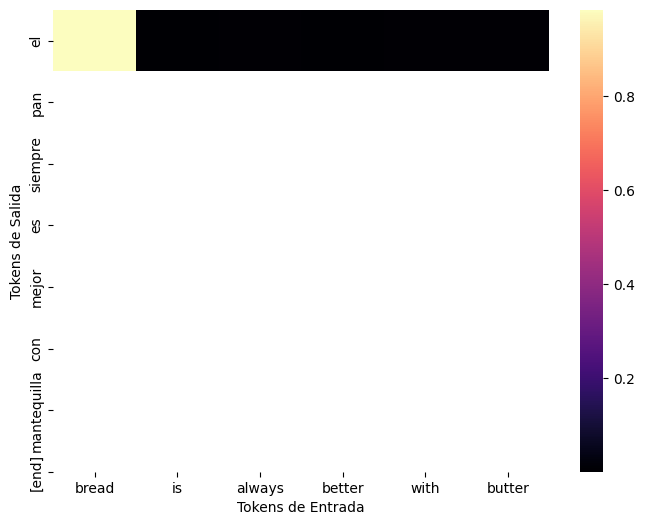

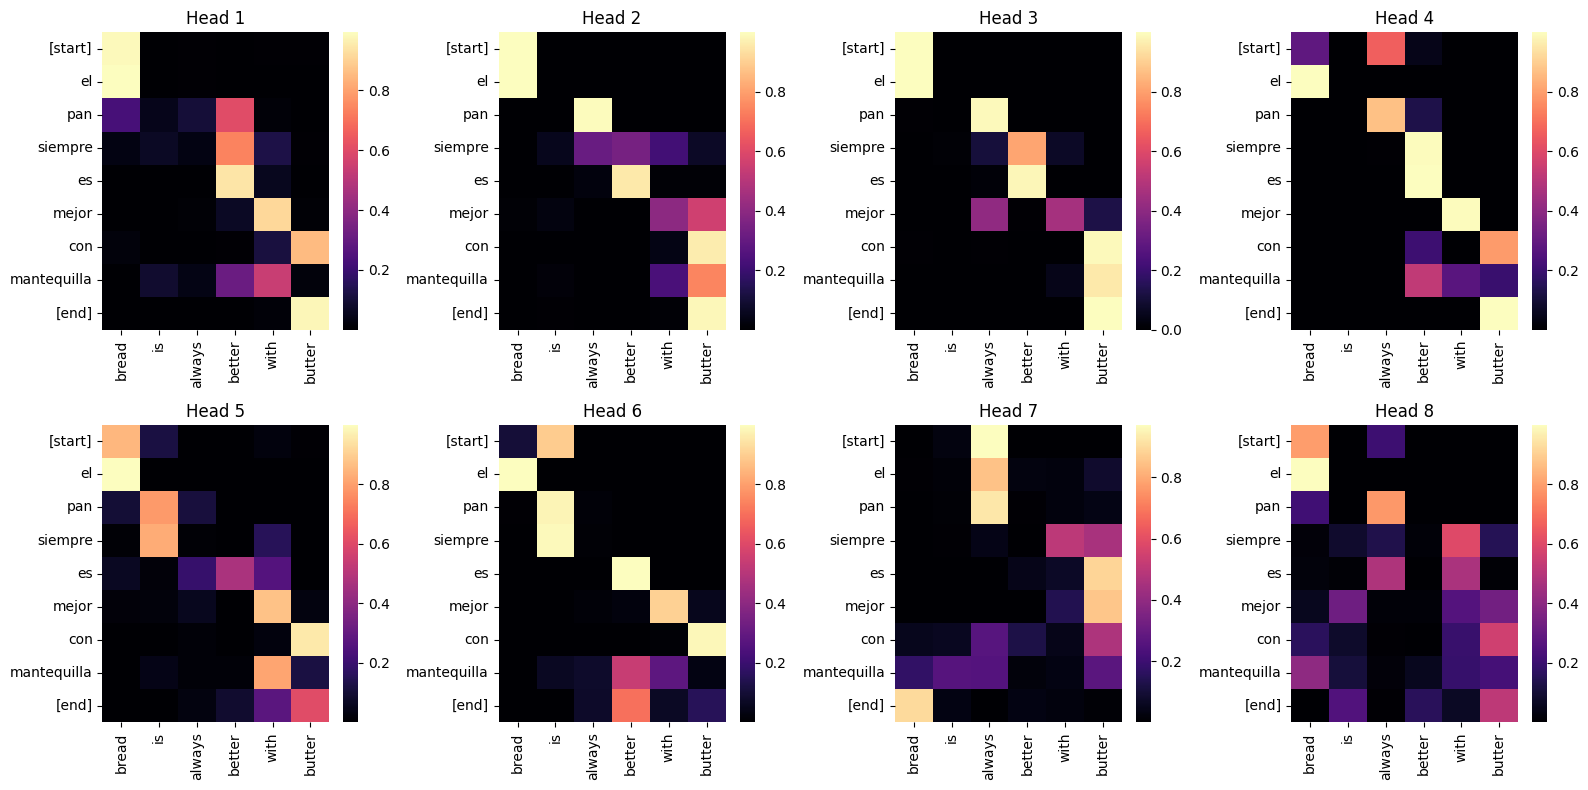


 Cargando modelo con Adam...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder

 Traducción (Adam): [start] el pan siempre es mejor [UNK] [end]
 Graficando atención final del modelo Adam...


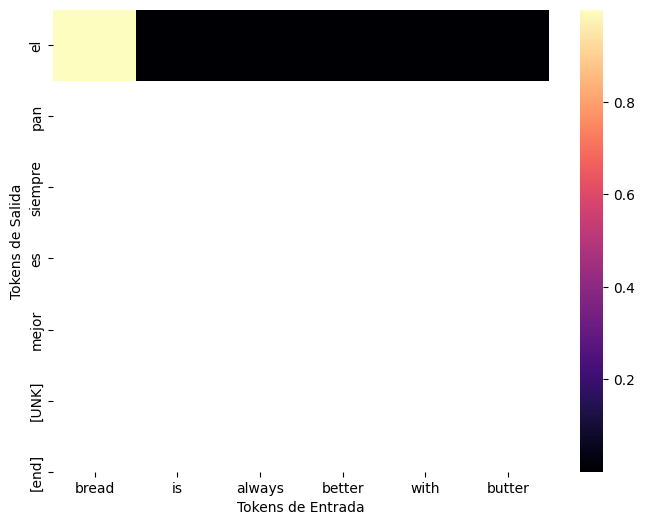

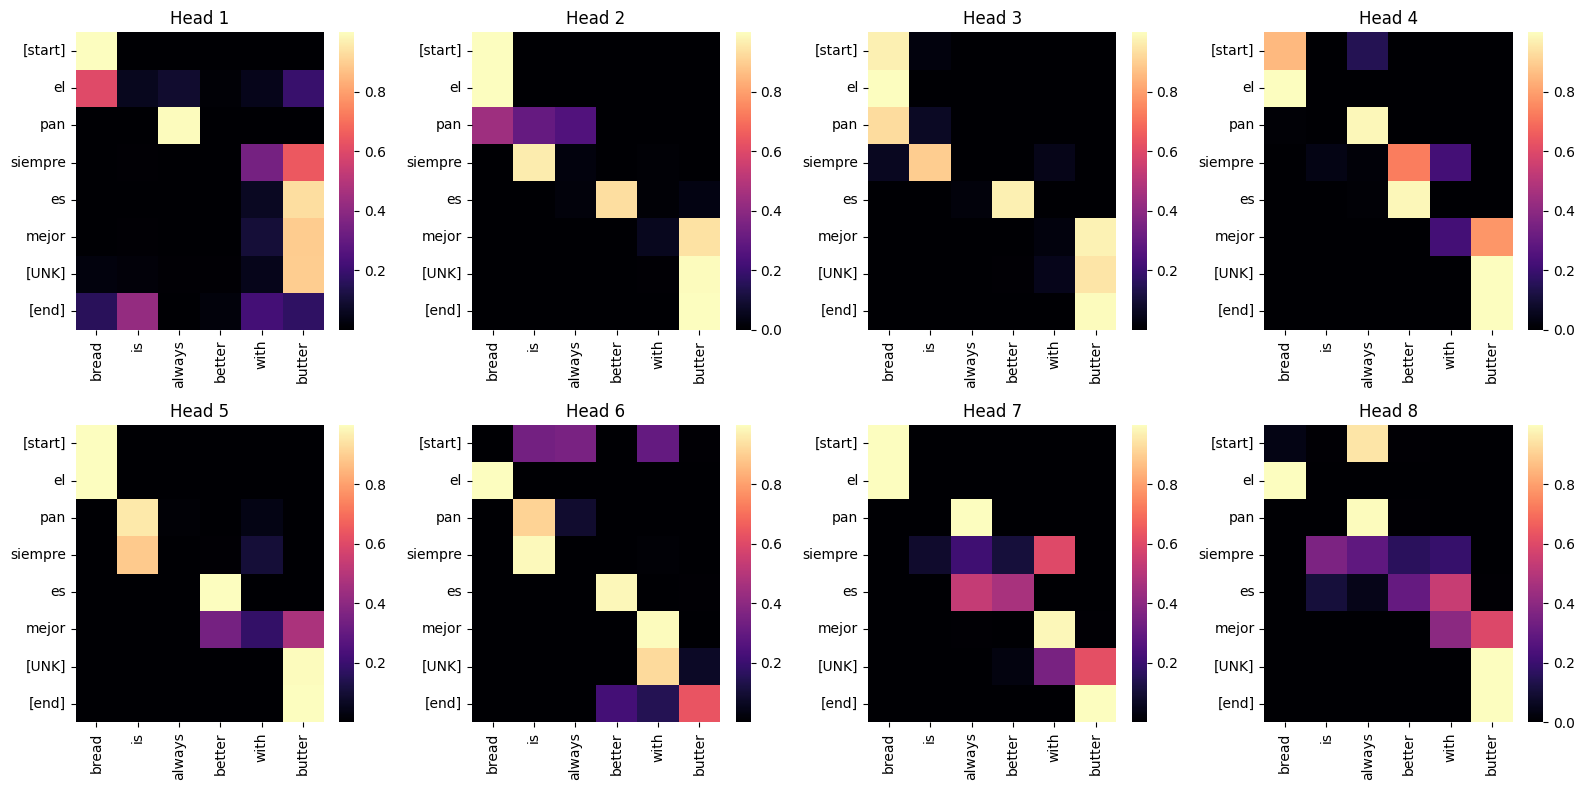


 Cargando modelo con SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encod

 Traducción (SGD): [start] tom no es un [UNK] [end]
 Graficando atención final del modelo SGD...


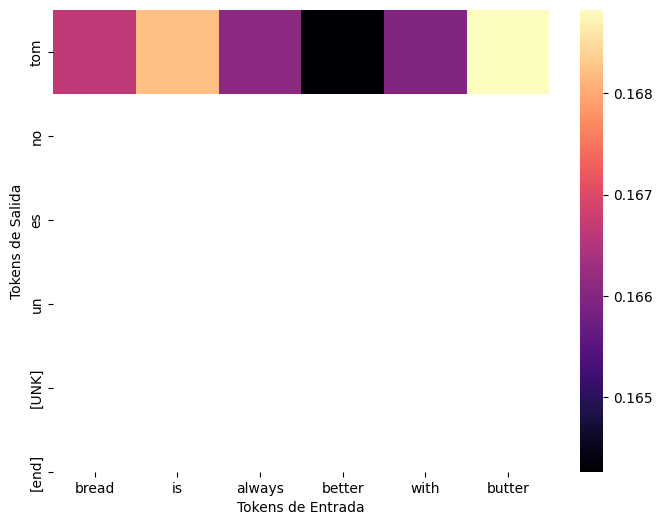

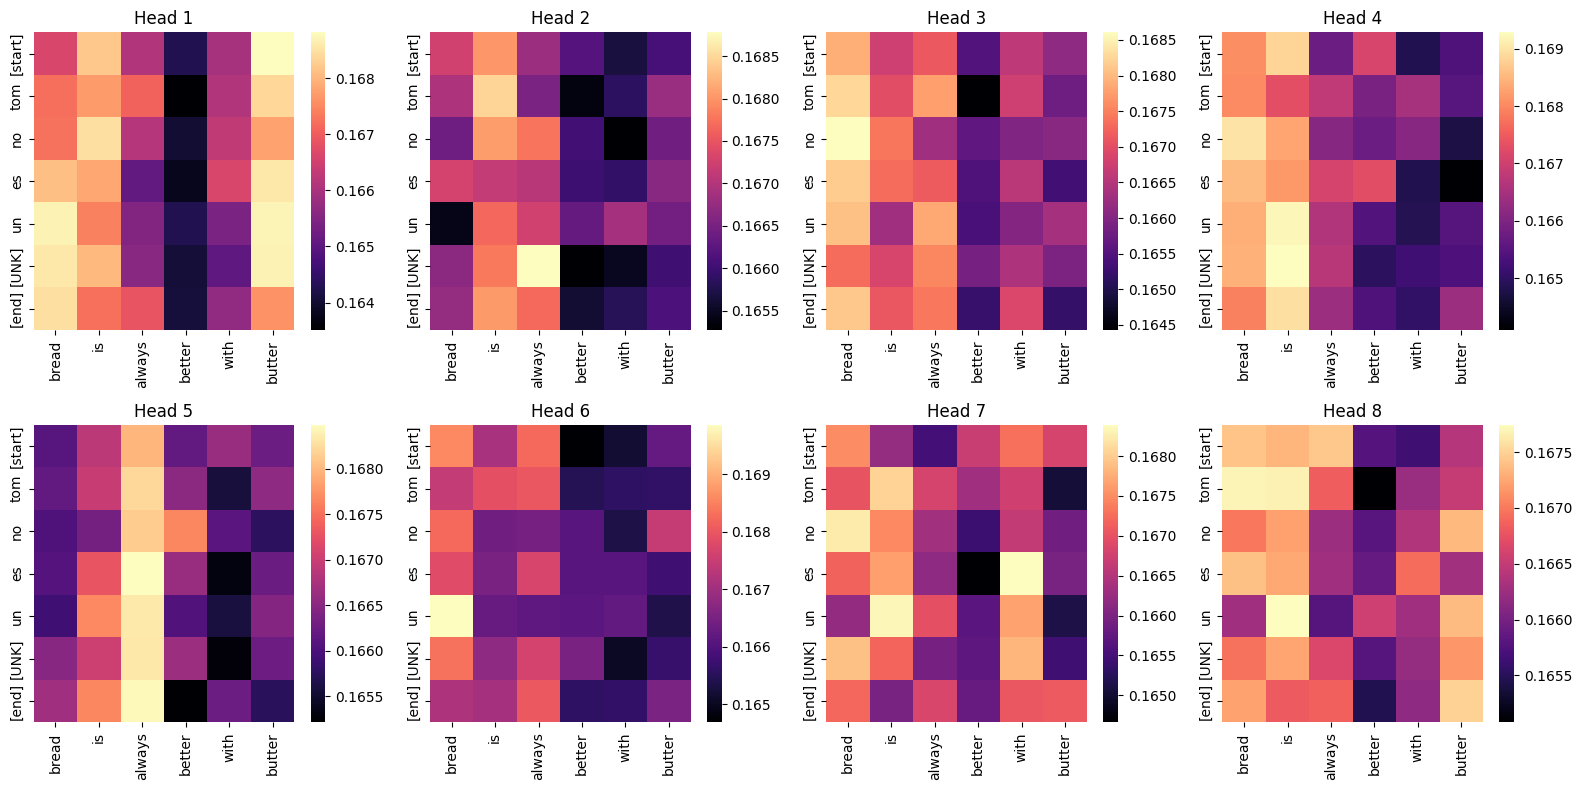


 Cargando modelo con Adagrad...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encod

 Traducción (Adagrad): [start] no es un poco de la [UNK] [end]
 Graficando atención final del modelo Adagrad...


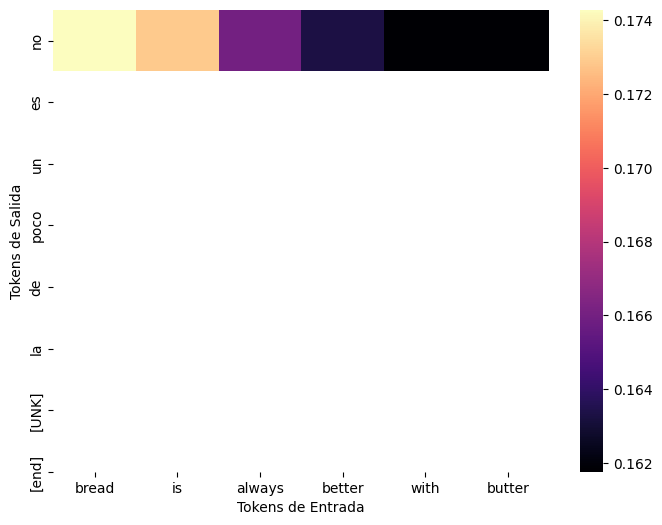

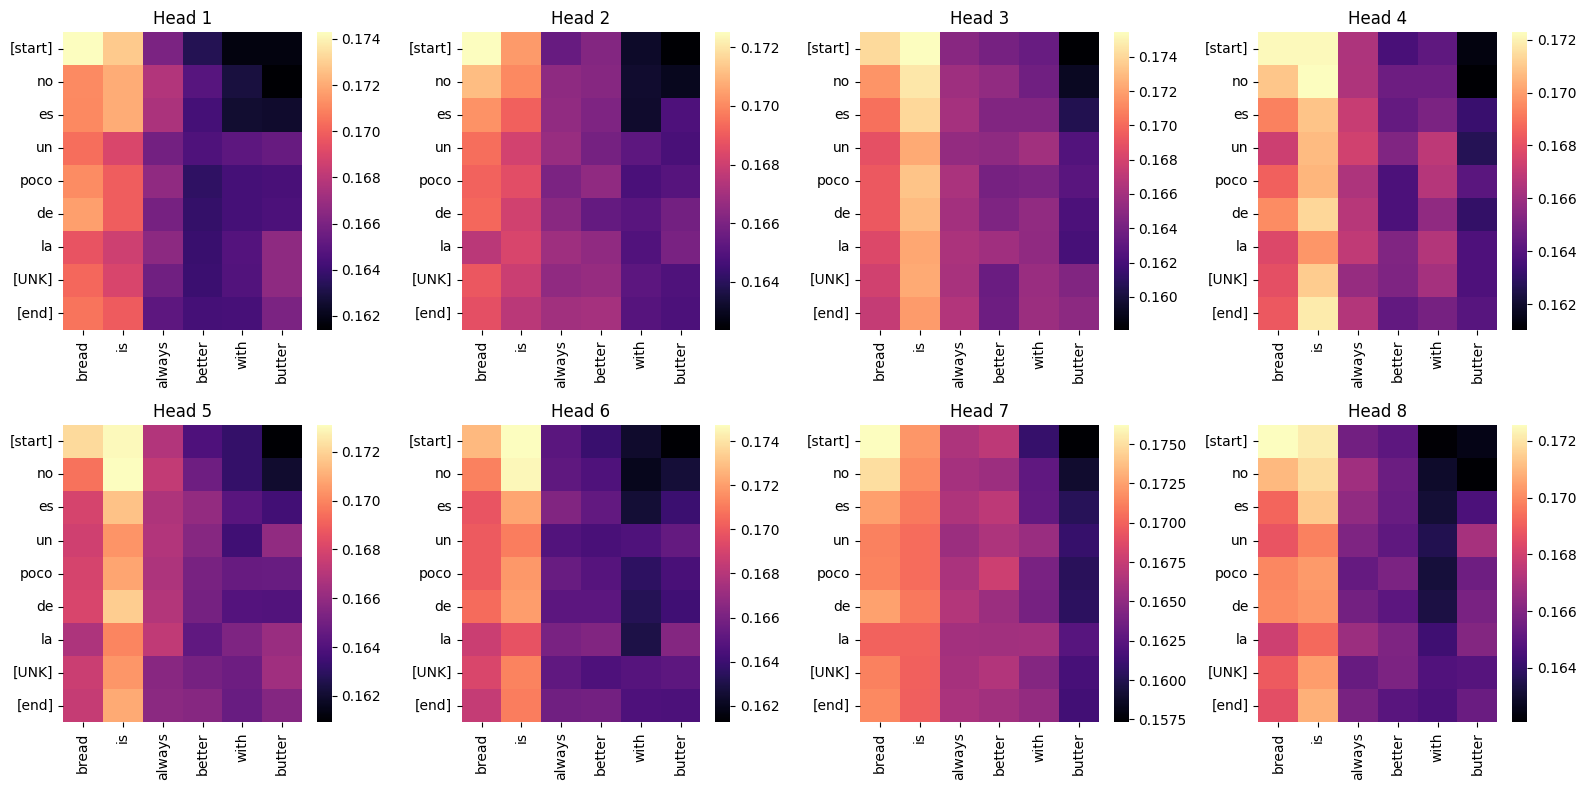

In [ ]:


# Generamos una lista con los optimizadores para serializar la operación
model_names = ["RMSprop", "Adam", "SGD", "Adagrad"]
input_sentence = "bread is always better with butter"

for opt in model_names:
    print(f"\n Cargando modelo con {opt}...")
    model_path = f"transformer_model_{opt}_with_attention.keras"

    try:
        model = load_model_with_attention(model_path)
        translated, attention_matrices = decode_sequence_with_attention(model, input_sentence)

        # Tokens traducidos
        tokenized = spa_vectorization([translated])
        vocab = spa_vectorization.get_vocabulary()
        translated_tokens = [vocab[i] for i in tokenized[0].numpy() if i != 0]
        input_tokens = input_sentence.split()

        # Último paso (última palabra generada)
        last_step_attention = attention_matrices[-1]  # (1, 8, seq_out, seq_in)
        last_step_attention = np.squeeze(last_step_attention, axis=0)  # (8, seq_out, seq_in)
        head_0 = last_step_attention[0][0]  # head 0, paso 0
        head_0 = np.expand_dims(head_0, axis=0)

        print(f" Traducción ({opt}): {translated}")
        print(f" Graficando atención final del modelo {opt}...")

        plot_attention_head(input_tokens, translated_tokens, head_0)
        plot_attention_weights(input_sentence, translated_tokens, last_step_attention)

    except Exception as e:
        print(f" Error con el modelo {opt}: {e}")



In [ ]:


# Descargar recursos necesarios para NLTK
nltk.download("punkt")
nltk.download("punkt_tab")

# Función BLEU
def compute_bleu(reference, hypothesis):
    reference_tokens = [nltk.word_tokenize(reference)]
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothing)

# Función ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

def compute_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return {
        "rouge1": scores["rouge1"].fmeasure,
        "rouge2": scores["rouge2"].fmeasure,
        "rougeL": scores["rougeL"].fmeasure,
    }

# Frase a traducir
input_sentence = "bread is always better with butter"
# Referencia para evaluar al modelo
reference_sentence = "el pan siempre es mejor con mantequilla"

results = []

for opt in model_names:
    print(f"\n Evaluando modelo con {opt}...")
    model_path = f"transformer_model_{opt}_with_attention.keras"

    try:
        model = load_model_with_attention(model_path)
        translated, _ = decode_sequence_with_attention(model, input_sentence)
        cleaned_translation = translated.replace("[start]", "").replace("[end]", "").strip()

        # Métricas
        bleu_score = compute_bleu(reference_sentence, cleaned_translation)
        rouge_scores = compute_rouge(reference_sentence, cleaned_translation)

        results.append([
            opt,
            cleaned_translation,
            bleu_score,
            rouge_scores["rouge1"],
            rouge_scores["rouge2"],
            rouge_scores["rougeL"],
        ])

    except Exception as e:
        print(f"Error con el modelo {opt}: {e}")
        results.append([opt, "Error", 0.0, 0.0, 0.0, 0.0])

# Mostrar tabla comparativa
df_results = pd.DataFrame(results, columns=["Optimizador", "Traducción", "BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"])

df_results.set_index("Optimizador", inplace=True)
display(df_results)






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may c


 Evaluando modelo con RMSprop...

 Evaluando modelo con Adam...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder


 Evaluando modelo con SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encod


 Evaluando modelo con Adagrad...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encod

,Traducción,BLEU,ROUGE-1,ROUGE-2,ROUGE-L
Optimizador,,,,,
RMSprop,el pan siempre es mejor con mantequilla,1.000000,1.000000,1.000000,1.000000
Adam,el pan siempre es mejor [UNK],0.516973,0.769231,0.727273,0.769231
SGD,tom no es un [UNK],0.033032,0.166667,0.000000,0.166667
Adagrad,no es un poco de la [UNK],0.023980,0.142857,0.000000,0.142857


## 2 Resultados

### 2.1 Comparación de perdida y precisión

Se entrenaron cuatro versiones del modelo Transformer utilizando diferentes optimizadores: RMSprop, Adam, SGD y Adagrad. De las gráficas comparativas de la pérdida y la precisión para las treinta epocas se puede ver que:

- Gráfica de Precisión: Adam y RMSprop logran mejores valores de precisión en comparación con SGD y Adagrad, que presentan un aprendizaje más lento y menos efectivo.

- Gráfica de Pérdida: Adam muestra la convergencia más rápida, mientras que RMSprop también logra una reducción significativa en la pérdida. En contraste, SGD y Adagrad presentan una reducción más lenta y estabilizan en valores más altos.

### 2.2 Métricas BLEU y ROUGE

Para evaluar la calidad de las traducciones generadas por cada optimizador, se calcularon las métricas **BLEU** y **ROUGE** utilizando la frase de prueba:
**"bread is always better with butter"**.

Considerando los resultados obtenidos como:

| Optimizador | Traducción Generada                          | BLEU   | ROUGE-1 | ROUGE-2 | ROUGE-L |
|-------------|-----------------------------------------------|--------|---------|---------|---------|
| RMSprop     | **el pan siempre es mejor con mantequilla**       | 1.000  | 1.000   | 1.000   | 1.000   |
| Adam        | el pan siempre es mejor [UNK]                 | 0.517  | 0.769   | 0.727   | 0.769   |
| SGD         | tom no es un [UNK]                            | 0.033  | 0.167   | 0.000   | 0.167   |
| Adagrad     | no es un poco de la [UNK]                     | 0.024  | 0.143   | 0.000   | 0.143   |




### 2.3 Graficas de atención

Para analizar cómo el modelo asigna atención a diferentes palabras en la traducción, se generaron mapas de atención multi-heads para las traducciones obtenidas. Estas matrices muestran qué palabras en la entrada influenciaron la generación de cada palabra en la salida.

Observaciones clave:

- Se observa que el modelo, en los casos de **SGD** y **Adagrad**, tiende a enfocarse en los primeros tokens de la oración, lo que podría estar afectando la calidad de la traducción.

- Algunas cabezas de atención muestran un comportamiento más disperso, mientras que otras parecen enfocarse en patrones más estructurados, como **RMSprop** y **Adam**.

- La aparición de tokens [UNK] sugiere que el modelo no logra mapear correctamente algunas palabras del vocabulario.

## 3 Conclusiones

**RMSprop** fue el optimizador que obtuvo el mejor desempeño en todas las métricas evaluadas (BLEU, ROUGE-1, ROUGE-2 y ROUGE-L), generando una traducción idéntica a la frase de referencia. Esto indica que el modelo logró aprender adecuadamente la secuencia objetivo y mantener una alta fidelidad al contenido original.

Sin embargo, sería interesante probar si las métricas del optimizador no indican un sobre ajusto del modelo con el optimizador **RMSprop**.

En el caso de **Adam**, se posicionó como el segundo mejor optimizador, con resultados aceptables en métricas **ROUGE**; sin embargo, su traducción perdió una palabra sustituida por [UNK], lo que afectó el puntaje **BLEU** y redujo la precisión general.

Por otro lado, **SGD** y **Adagrad** obtuvieron los peores resultados, tanto en las métricas, como en la calidad de la traducción. Ambas salidas fueron incoherentes y con pérdida significativa de significado respecto a la oración de referencia.

La presencia del token [UNK] indica que algunas palabras no fueron reconocidas o generadas correctamente, lo cual podría mitigarse con un vocabulario más amplio, de hecho, la frase original a traducir iba a ser **Quesadillas must have chesse"**, pero ya que la palabra *Quesadilla* dificilmente esta en este tipo de vocabularios, se generaba mucho ruido..

finalmente, podemos hablar de que la elección del optimizador tiene un impacto significativo en la calidad de las traducciones generadas por el modelo **Transformer**, sustentado sobre el hecho de que los cuatro optimizadores entrenaron sobre los mismos datos y sobre el mismo número de epocas.